# Data analysis with Python, Apache Spark,  and PixieDust
***

In this notebook you will:

* analyze customer demographics, such as, age, gender, income, and location
* combine that data with sales data to examine trends for product categories, transaction types, and product popularity
* load data from GitHub as well as from a public open data set
* cleanse, shape, and enrich the data, and then visualize the data with the PixieDust library

Don't worry! PixieDust graphs don't require coding. 

By the end of the notebook, you will understand how to combine data to gain insights about which customers you might target to increase sales.

This notebook runs on Python 2 with Spark 2.1, and PixieDust 1.1.10.

# <a id="toc"></a>
## Table of contents

#### [Setup](#Setup)
[Load data into the notebook](#Load-data-into-the-notebook)
#### [Explore customer demographics](#part1)
[Prepare the customer data set](#Prepare-the-customer-data-set)<br>
[Visualize customer demographics and locations](#Visualize-customer-demographics-and-locations)<br>
[Enrich demographic information with open data](#Enrich-demographic-information-with-open-data)<br>   

#### [Summary and next steps](#summary)

## Setup
You need to import libraries and load the customer data into this notebook.

Import the necessary libraries:

In [1]:
import pixiedust
import pyspark.sql.functions as func
import pyspark.sql.types as types
import re
import json
import os
import requests  

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191111162944-0001
KERNEL_ID = 072766f8-d558-4fc6-a286-a35b56dcbd2d
Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


**If you get any errors or if a package is out of date:**

* uncomment the lines in the next cell (remove the `#`)
* restart the kernel (from the Kernel menu at the top of the notebook)
* reload the browser page
* run the cell above, and continue with the notebook

In [2]:
!pip install --user --upgrade pixiedust

    100% |################################| 204kB 4.5MB/s eta 0:00:01
    100% |################################| 798kB 3.8MB/s eta 0:00:01
    100% |################################| 5.8MB 2.2MB/s eta 0:00:01
    100% |################################| 92kB 5.4MB/s eta 0:00:01
    100% |################################| 61kB 2.9MB/s eta 0:00:01
    100% |################################| 583kB 5.3MB/s eta 0:00:01
    100% |################################| 163kB 5.4MB/s eta 0:00:01
    100% |################################| 133kB 5.6MB/s eta 0:00:01
    100% |################################| 61kB 3.5MB/s eta 0:00:01
    100% |################################| 143kB 6.7MB/s eta 0:00:01
  Stored in directory: /home/spark/shared/.cache/pip/wheels/25/fa/a5/09c1e8f4c91b34c5f7f4ac6e41be81dd0667030a2372546a8d
  Stored in directory: /home/spark/shared/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built pixiedust mpld3
tensorflow 1.13.1 requires t

In [3]:
#!pip install jinja2 --user --upgrade
#!pip install pixiedust --user --upgrade
#!pip install -U --no-deps bokeh

### Load data into the notebook

The data file contains both the customer demographic data that you'll analyzed in Part 1, and the sales transaction data for Part 2.

With `pixiedust.sampleData()` you can load csv data from any url. The below loads the data in a Spark DataFrame. 

> In case you wondered, this works with Pandas as well, just add `forcePandas = True` to load data in a Pandas DataFrame. *But do not add this to the below cell as in this notebook you will use Spark.*

In [4]:
raw_df = pixiedust.sampleData('https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/customers_orders1_opt.csv')

Downloaded 5648773 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/customers_orders1_opt.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/customers_orders1_opt.csv'


In [5]:
raw_df

DataFrame[CUSTNAME: string, GenderCode: string, ADDRESS1: string, CITY: string, STATE: string, COUNTRY_CODE: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, ADDRESS2: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, CREDITCARD_TYPE: string, LOCALITY: string, SALESMAN_ID: string, NATIONALITY: string, NATIONAL_ID: string, CREDITCARD_NUMBER: bigint, DRIVER_LICENSE: string, CUST_ID: int, ORDER_ID: int, ORDER_DATE: timestamp, ORDER_TIME: timestamp, FREIGHT_CHARGES: double, ORDER_SALESMAN: string, ORDER_POSTED_DATE: timestamp, ORDER_SHIP_DATE: string, AGE: string, ORDER_VALUE: double, T_TYPE: string, PURCHASE_TOUCHPOINT: string, PURCHASE_STATUS: string, ORDER_TYPE: string, GENERATION: string, Baby Food: int, Diapers: int, Formula: int, Lotion: int, Baby wash: int, Wipes: int, Fresh Fruits: int, Fresh Vegetables: int, Beer: int, Wine: int, Club Soda: int, Sports Drink: int, Chips: int, Popcorn: int, Oatmeal: int, Medicines: int, Canned Foods: int, Cigarettes: int, Cheese: int, Cleani

[Back to Table of Contents](#toc)
<a id="part1"></a>
# Explore customer demographics 
In this part of the notebook, you will prepare the customer data and then start learning about your customers by creating multiple charts and maps. 

## Prepare the customer data set
Create a new Spark DataFrame with only the data you need and then cleanse and enrich the data.

Extract the columns that you are interested in, remove duplicate customers, and add a column for aggregations:

In [6]:
# Extract the customer information from the data set
customer_df = raw_df.select("CUST_ID", 
                            "CUSTNAME", 
                            "ADDRESS1", 
                            "ADDRESS2", 
                            "CITY", 
                            "POSTAL_CODE", 
                            "POSTAL_CODE_PLUS4", 
                            "STATE", 
                            "COUNTRY_CODE", 
                            "EMAIL_ADDRESS", 
                            "PHONE_NUMBER",
                            "AGE",
                            "GenderCode",
                            "GENERATION",
                            "NATIONALITY", 
                            "NATIONAL_ID", 
                            "DRIVER_LICENSE").dropDuplicates()

customer_df.printSchema()

root
 |-- CUST_ID: integer (nullable = true)
 |-- CUSTNAME: string (nullable = true)
 |-- ADDRESS1: string (nullable = true)
 |-- ADDRESS2: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- POSTAL_CODE: string (nullable = true)
 |-- POSTAL_CODE_PLUS4: integer (nullable = true)
 |-- STATE: string (nullable = true)
 |-- COUNTRY_CODE: string (nullable = true)
 |-- EMAIL_ADDRESS: string (nullable = true)
 |-- PHONE_NUMBER: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- GenderCode: string (nullable = true)
 |-- GENERATION: string (nullable = true)
 |-- NATIONALITY: string (nullable = true)
 |-- NATIONAL_ID: string (nullable = true)
 |-- DRIVER_LICENSE: string (nullable = true)



Notice that the data type of the AGE column is currently a string. Convert the AGE column to a numeric data type so you can run calculations on customer age.

In [7]:
# ---------------------------------------
# Cleanse age (enforce numeric data type) 
# ---------------------------------------

def getNumericVal(col):
    """
    input: pyspark.sql.types.Column
    output: the numeric value represented by col or None
    """
    try:
      return int(col)
    except ValueError:
      # age-33
      match = re.match('^age\-(\d+)$', col)
      if match:
        try:
          return int(match.group(1))
        except ValueError:    
          return None
      return None  

toNumericValUDF = func.udf(lambda c: getNumericVal(c), types.IntegerType())
customer_df = customer_df.withColumn("AGE", toNumericValUDF(customer_df["AGE"]))
customer_df

DataFrame[CUST_ID: int, CUSTNAME: string, ADDRESS1: string, ADDRESS2: string, CITY: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, STATE: string, COUNTRY_CODE: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, AGE: int, GenderCode: string, GENERATION: string, NATIONALITY: string, NATIONAL_ID: string, DRIVER_LICENSE: string]

In [8]:
customer_df.show(5)

+-------+--------------------+--------------------+--------+-------------------+-----------+-----------------+-----+------------+--------------------+--------------+---+----------+------------+-----------+-----------+--------------+
|CUST_ID|            CUSTNAME|            ADDRESS1|ADDRESS2|               CITY|POSTAL_CODE|POSTAL_CODE_PLUS4|STATE|COUNTRY_CODE|       EMAIL_ADDRESS|  PHONE_NUMBER|AGE|GenderCode|  GENERATION|NATIONALITY|NATIONAL_ID|DRIVER_LICENSE|
+-------+--------------------+--------------------+--------+-------------------+-----------+-----------------+-----+------------+--------------------+--------------+---+----------+------------+-----------+-----------+--------------+
|  10311|Rosemary Herbert    |3591 Nutters Barn...|    null|      Beverly Hills|      90210|                0|   CA|          US|Rosemary.J.Herber...|  814-393-3387| 40|      Mrs.|       Gen_Y|       U.S.|   22868377|          null|
|  10347|Reynaldo Myers      |3923 Black Stalli...|    null|      Bl

The GenderCode column contains salutations instead of gender values. Derive the gender information for each customer based on the salutation and rename the GenderCode column to GENDER.

In [9]:
# ------------------------------
# Derive gender from salutation
# ------------------------------
def deriveGender(col):
    """ input: pyspark.sql.types.Column
        output: "male", "female" or "unknown"
    """    
    if col in ['Mr.', 'Master.']:
        return 'male'
    elif col in ['Mrs.', 'Miss.']:
        return 'female'
    else:
        return 'unknown';
    
deriveGenderUDF = func.udf(lambda c: deriveGender(c), types.StringType())
customer_df = customer_df.withColumn("GENDER", deriveGenderUDF(customer_df["GenderCode"]))
customer_df.cache()

DataFrame[CUST_ID: int, CUSTNAME: string, ADDRESS1: string, ADDRESS2: string, CITY: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, STATE: string, COUNTRY_CODE: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, AGE: int, GenderCode: string, GENERATION: string, NATIONALITY: string, NATIONAL_ID: string, DRIVER_LICENSE: string, GENDER: string]

## Explore the customer data set

Instead of exploring the data with `.printSchema()` and `.show()` you can quickly explore data sets using PixieDust'. Invoke the `display()` command and click the table icon to review the schema and preview the data. Customize the options to display only a subset of the fields or rows or apply a filter (by clicking the funnel icon).

In [ ]:
display(customer_df)

[Back to Table of Contents](#toc)
## Visualize customer demographics and locations

Now you are ready to explore the customer base. Using simple charts, you can quickly see these characteristics:
 * Customer demographics (gender and age)
 * Customer locations (city, state, and country)

You will create charts with the PixieDust library:

 - [View customers by gender in a pie chart](#View-customers-by-gender-in-a-pie-chart)
 - [View customers by generation in a bar chart](#View-customers-by-generation-in-a-bar-chart)
 - [View customers by age in a histogram chart](#View-customers-by-age-in-a-histogram-chart)
 - [View specific information with a filter function](#View-specific-information-with-a-filter-function)
 - [View customer density by location with a map](#View-customer-density-by-location-with-a-map)

### View customers by gender in a pie chart

Run the `display()` command and then configure the graph to show the percentages of male and female customers:

1. Run the next cell. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Pie Chart**. The chart options tool appears.
1. In the chart options, drag `GENDER` into the **Keys** box. 
1. In the **Aggregation** field, choose **COUNT**. 
1. Increase the **# of Rows to Display** to a very large number to display all data.
1. Click **OK**. The pie chart appears.

If you want to make further changes, click **Options** to return to the chart options tool.

In [ ]:
display(customer_df)

[Back to Table of Contents](#toc)
### View customers by generation in a bar chart
Look at how many customers you have per "generation."

Run the next cell and configure the graph: 
1. Choose **Bar Chart** as the chart type and configure the chart options as instructed below.
2. Put `GENERATION` into the **Keys** box.
3. Set **aggregation** to `COUNT`.
1. Increase the **# of Rows to Display** to a very large number to display all data.
4. Click **OK**
4. Change the **Renderer** at the top right of the chart to explore different visualisations.  
4. You can use clustering to group customers, for example by geographic location. To group generations by country, select `COUNTRY_CODE` from the **Cluster by** list from the menu on the left of the chart. 

In [ ]:
display(customer_df)

[Back to Table of Contents](#toc)
### View customers by age in a histogram chart
A generation is a broad age range. You can look at a smaller age range with a histogram chart. A histogram is like a bar chart except each bar represents a range of numbers, called a bin. You can customize the size of the age range by adjusting the bin size. The more bins you specify, the smaller the age range.

Run the next cell and configure the graph:
1. Choose **Histogram** as the chart type. 
2. Put `AGE` into the **Values** box.
1. Increase the **# of Rows to Display** to a very large number to display all data.
1. Click **OK**.
3. Use the **Bin count** slider to specify the number of the bins. Try starting with 40.


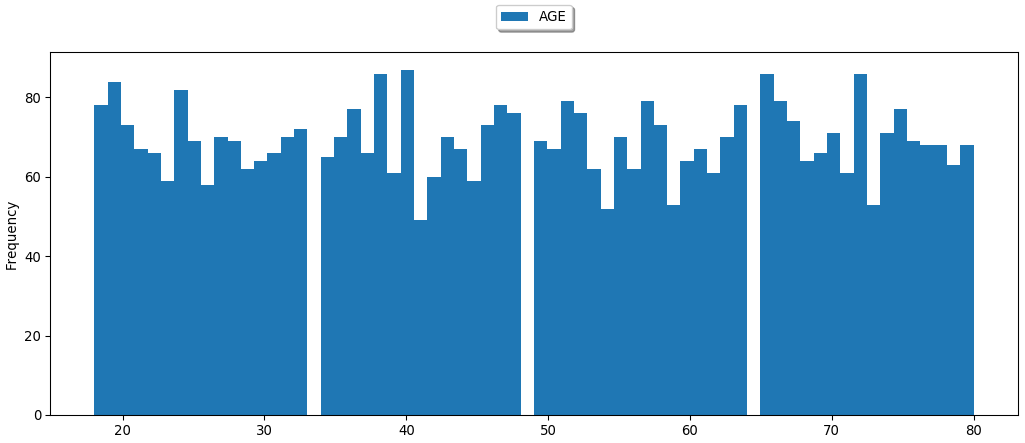

In [ ]:
display(customer_df)

[Back to Table of Contents](#toc)
### View specific information with a filter function

You can filter records to restrict analysis by using the [PySpark DataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) `filter()` function.

If you want to view the age distribution for a specific generation, uncomment the desired filter condition and run the next cell:


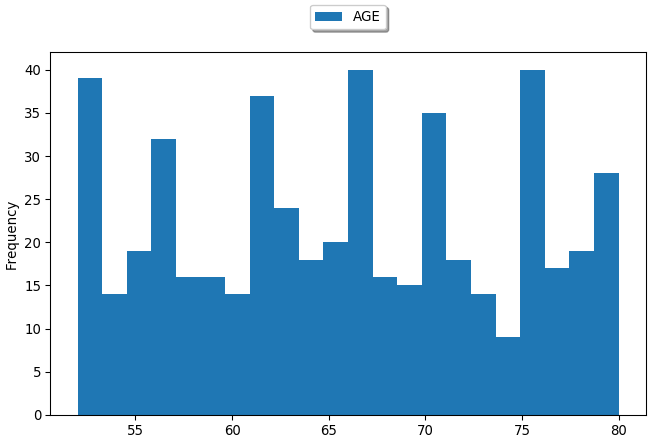

In [ ]:
# Data subsetting: display age distribution for a specific generation
# (Chart type: histogram, Chart Options > Values: AGE)
# to change the filter condition remove the # sign 
condition = "GENERATION = 'Baby_Boomers'"
#condition = "GENERATION = 'Gen_X'"
#condition = "GENERATION = 'Gen_Y'"
#condition = "GENERATION = 'Gen_Z'"
boomers_df = customer_df.filter(condition)
display(boomers_df)

PixieDust supports basic filtering to make it easy to analyse data subsets. For example, to view the age distribution for a specific gender configure the chart as follows:

  1. Choose `Histogram` as the chart type.
  2. Put `AGE` into the **Values** box and click OK.
  3. Click the filter button (looking like a funnel), and choose **GENDER** as field and `female` as value.
  
The filter is only applied to the working data set and does not modify the input `customer_df`.


In [ ]:
display(customer_df)

You can also filter by location. For example, the following command creates a new DataFrame that filters for customers from the USA:

In [16]:
condition = "COUNTRY_CODE = 'US'"
us_customer_df = customer_df.filter(condition)

You can pivot your analysis perspective based on aspects that are of interest to you by choosing different keys and clusters.

Create a bar chart and cluster the data.

Run the next cell and configure the graph:
1. Choose **Bar chart** as the chart type.
2. Put `COUNTRY_CODE` into the **Keys** box.
4. Set Aggregation to **COUNT**.
5. Click **OK**. The chart displays the number of US customers.
6. From the **Cluster By** list, choose **GENDER**. The chart shows the number of customers by gender.

In [ ]:
display(us_customer_df)

Now try to cluster the customers by state.

A bar chart isn't the best way to show geographic location!

[Back to Table of Contents](#toc)
### View customer density by location with a map
Maps are a much better way to view location data than other chart types. 

Visualize customer density by US state with a map.

Run the next cell and configure the graph:
1. Choose **Map** as the chart type.
2. Put `STATE` into the **Keys** box.
4. Set Aggregation to **COUNT**.
5. Click **OK**. The map displays the number of US customers.
6. From the **Renderer** list, choose **brunel**.

    > PixieDust supports three map renderers: brunel, [mapbox](https://www.mapbox.com/) and Google. Note that the Mapbox renderer and the Google renderer require an API key or access token and supported features vary by renderer.

7. You can explore more about customers in each state by changing the aggregation method, for example look at customer age ranges (avg, minimum, and maximum) by state. Simply Change the aggregation function to `AVG`, `MIN`, or `MAX` and choose `AGE` as value. 


In [18]:
display(us_customer_df)

[Back to Table of Contents](#toc)
## Enrich demographic information with open data
You can easily combine other sources of data with your existing data. There is a lot of publicly available open data sets that can be very helpful. For example, knowing the approximate income level of your customers might help you target your marketing campaigns.

Run the next cell to load [this data set](https://apsportal.ibm.com/exchange/public/entry/view/beb8c30a3f559e58716d983671b70337) from the United States Census Bureau into your notebook. The data set contains US household income statistics compiled at the zip code geography level.

In [19]:
# Load median income information for all US ZIP codes from a public source
income_df = pixiedust.sampleData('https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/x19_income_select.csv')

Downloaded 6007673 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/x19_income_select.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/IBM/analyze-customer-data-spark-pixiedust/master/data/x19_income_select.csv'


In [20]:
income_df.printSchema()

root
 |-- GEOID: string (nullable = true)
 |-- B19049e1: integer (nullable = true)
 |-- B19049e2: integer (nullable = true)
 |-- B19049e3: integer (nullable = true)
 |-- B19049e4: integer (nullable = true)
 |-- B19049e5: integer (nullable = true)
 |-- B19050e1: integer (nullable = true)
 |-- B19050e2: integer (nullable = true)
 |-- B19050e3: integer (nullable = true)
 |-- B19050e4: integer (nullable = true)
 |-- B19050e5: integer (nullable = true)
 |-- B19051e1: integer (nullable = true)
 |-- B19051e2: integer (nullable = true)
 |-- B19051e3: integer (nullable = true)
 |-- B19052e1: integer (nullable = true)
 |-- B19052e2: integer (nullable = true)
 |-- B19052e3: integer (nullable = true)
 |-- B19053e1: integer (nullable = true)
 |-- B19053e2: integer (nullable = true)
 |-- B19053e3: integer (nullable = true)
 |-- B19054e1: integer (nullable = true)
 |-- B19054e2: integer (nullable = true)
 |-- B19054e3: integer (nullable = true)
 |-- B19055e1: integer (nullable = true)
 |-- B19055e2: 

Now cleanse the income data set to remove the data that you don't need. Create a new DataFrame for this data:
 - The zip code, extracted from the GEOID column.
 - The column B19049e1, which contains the median household income for 2013.

In [21]:
# ------------------------------
# Helper: Extract ZIP code
# ------------------------------
def extractZIPCode(col):
    """ input: pyspark.sql.types.Column containing a geo code, like '86000US01001'
        output: ZIP code
    """
    m = re.match('^\d+US(\d\d\d\d\d)$',col)
    if m:
        return m.group(1)
    else:
        return None    
    
getZIPCodeUDF = func.udf(lambda c: extractZIPCode(c), types.StringType())
income_df = income_df.select('GEOID', 'B19049e1').withColumnRenamed('B19049e1', 'MEDIAN_INCOME_IN_ZIP').withColumn("ZIP", getZIPCodeUDF(income_df['GEOID']))
income_df

DataFrame[GEOID: string, MEDIAN_INCOME_IN_ZIP: int, ZIP: string]

Perform a left outer join on the customer data set with the income data set, using the zip code as the join condition. For the complete syntax of joins, go to the <a href="https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame" target="_blank" rel="noopener noreferrer">pyspark DataFrame documentation</a> and scroll down to the `join` syntax. 

In [22]:
us_customer_df = us_customer_df.join(income_df, us_customer_df.POSTAL_CODE == income_df.ZIP, 'left_outer').drop('GEOID').drop('ZIP')


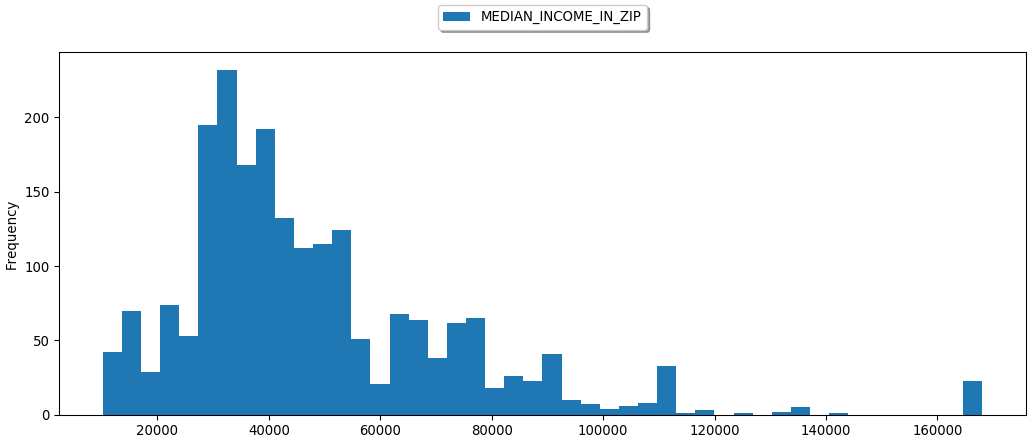

In [ ]:
display(us_customer_df)

Now you can visualize the income distribution of your customers by zip code.
 Visualize income distribution for our customers.
Run the next cell and configure the graph:
1. Choose **Histogram** as the chart type.
2. Put `MEDIAN_INCOME_IN_ZIP` into the **Values** box and click **OK**.

The majority of your customers live in zip codes where the median income is around 40,000 USD. 

[Back to Table of Contents](#toc)


Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.